### Imports

In [1]:
import numpy as np
from pandas import to_datetime
from bond_pricing import bond_coupon_periods, bond_duration
from scipy.optimize import newton

In [2]:
def equivRate(rate, from_freq=1, to_freq=1):
  if from_freq == np.inf:
    return (np.exp(rate / to_freq) - 1) * to_freq
  elif to_freq == np.inf:
    return np.log(1 + rate / from_freq) * from_freq
  else:
    return to_freq * ((1 + rate/from_freq)**(from_freq/to_freq) - 1)

def coupon_bond_ytm(n, pmt, pv, fv=100, cf_freq=1, comp_freq=1, beg=False):
    def f(x):
        return coupon_bond_pv(n=n, pmt=pmt, rate=x, fv=fv, cf_freq=cf_freq, comp_freq=comp_freq, beg=beg) - pv
    root = newton(f, 0)
    return root

def coupon_bond_pv(n, pmt, rate, fv=100, cf_freq=1, comp_freq=1, beg=False):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    old_settings = np.seterr(invalid='ignore')
    pvPMT = np.where(rate == 0, n, np.divide(1 - (1+rate)**-n, rate)) * pmt
    np.seterr(**old_settings)
    pvFV = fv / (1 + rate)**n
    return np.where(beg, (pvPMT + pvFV) * (1 + rate), pvPMT + pvFV)

def coupon_bond_fv(n, pmt, rate, terminal_payment, cf_freq=1, comp_freq=1, beg=False):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    old_settings = np.seterr(invalid='ignore')
    fvPMT = np.where(rate == 0, n, np.divide((1+rate)**n - 1, rate)) * pmt
    np.seterr(**old_settings)        
    return np.where(beg, fvPMT * (1 + rate) + terminal_payment, fvPMT + terminal_payment)

def coupon_bond_pmt(n, rate, pv, fv, cf_freq=1, comp_freq=1):
    rate = equivRate(rate, from_freq=comp_freq, to_freq=cf_freq) / cf_freq
    pvaf = np.where(rate == 0, n, np.divide(1 - (1+rate)**-n, rate))
    return (pv - (fv/(1+rate)**n)) / pvaf

def zero_bond_ytm(n, pv, fv=100, freq=2):
    if freq == np.inf:
        return np.log(fv/pv) * (1/n)
    return ((fv/pv)**(1/(n*freq)) - 1) * freq

def zero_bond_pv(n, rate, fv=100, freq=2):
    if freq == np.inf:
        return fv / np.exp(rate*n)
    return fv / ((1 + rate/freq)**(n*freq))

def zero_bond_fv(n, rate, pv, freq):
    if freq == np.inf:
        return pv * np.exp(rate*n)    
    return pv * ((1 + rate/freq)**(n*freq))

def irr_newton(cf, cf_t, per=1):
    def price(rate, cf, cf_t, per=1):
        discount_factor = (1 + rate/per)**(-cf_t)
        return np.dot(cf, discount_factor)
    def f(x):
        return price(x, cf, cf_t, per=per)
    return newton(f, 0)

def irr_newton_no_scipy(stream, cf_t, per=1, tol=1e-12):
    rate = 0.0
    for steps in range(50): 
        r = np.array(cf_t)
        m = max(-rate * r / per)  
        f = np.exp(-rate * r / per - m)
        t = np.dot(f, stream)
        if abs(t) < tol * np.exp(-m):
            break
        u = np.dot(f * r, stream)
        rate = rate + np.clip(t / u, -1.0, 1.0)
    annualized_rate = (np.exp(rate / per) - 1) * per 
    return annualized_rate

def ifr(rate_t0t1, t1, rate_t0t2, t2, t0 = 0, per=2):
    t2_term = (1 + rate_t0t2/per)**(t2 - t0)
    t1_term = (1 + rate_t0t1/per)**(t1 - t0) 
    return ((t2_term / t1_term)**(1/(t2 - t1)) - 1) * per

def ifr_mm(rate_t0t1, t1, rate_t0t2, t2, t0 = 0, year=360, aor=True):
    rollover_avg = (t2 * rate_t0t2 - t1 * rate_t0t1) / (t2 - t1)
    adjust = 1/(1 + (rate_t0t1 * t1/year)) if aor else 1/(1 - (rate_t0t1 * t1/year))
    return rollover_avg * adjust

In [3]:
def duration(N, r, c, tT, cf_freq=2, comp_freq=2, modified=True):
    r = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq 
    dur = ((1 + r)/r) - ((1 + r + N * (c - r))/(c * ((1 + r)**N - 1) + r)) - tT
    dur /= cf_freq
    return dur/(1 + r) if modified else dur

def duration_cf(N, r, cf, tT, cf_freq=2, comp_freq=2, modified=True):
    r = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq
    years = np.arange(N) + 1
    df = 1 / (1 + r)**(years)
    macdur = np.dot(cf*df, years) / np.dot(cf, df) - tT
    macdur /= cf_freq
    return macdur/(1 + r) if modified else macdur

def convexity(N, r, c, tT, cf_freq=2, comp_freq=2):
    y = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq
    Y = (1+y)**2
    Yn = (1+y)**N
    con_num = (2 * c * Y * (Yn - ((1+y+(y*N))/(1+y)))) + (N * (N + 1) * (y**2) * (y - c))
    con_den = (y**2) * Y * (c * (Yn - 1) + y)
    con = con_num / con_den
    print(f'{con = :0.4f}')
    
    macdur = ((1 + y)/y) - ((1 + y + (N * (c - y)))/(c * (Yn - 1) + y))
    print(f'{macdur = :0.4f}')
    
    con_tT = con - ((tT / Y) * (( 2 * macdur) + (1 - tT)))
    print(f'{con_tT = :0.4f}')
    return con_tT/cf_freq**2

def convexity_cf(r, cf, cf_t=None, N=None, tT=0, cf_freq=2, comp_freq=2):
    r = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq
    if cf_t is None:
        cf_t = np.arange(N) + 1 - tT
    pv_cf = cf * (1+r)**-cf_t
    weight = pv_cf / np.sum(pv_cf)
    cf_con = cf_t * (cf_t + 1) * weight * (1 + r)**-cf_freq
    return np.sum(cf_con)/cf_freq**2

### Introduction

Duration and convexity are statistics that estimate the sensitivity of the market value of an asset or liability to a change in interest rates. Usually the asset or liability is a fixed‐income bond, but as measures of rate sensitivity, they apply to all sorts of securities and derivatives. We can ask meaningfully about the duration and convexity of a floating‐rate note, an inflation‐indexed bond, or an interest rate swap.

- *Yield Duration* - the sensitivity of the bond price to a change in its yield to maturity, this includes the Macaulay and modified duration statistics.
- *Yield Convexity* - the second‐order effect of that yield change.
- *Curve Duration and Curve Convexity* - the sensitivity of the bond price to a shift in the benchmark Treasury yield curve.

Suppose that you are the fixed‐income strategist for an aggressively managed, high‐yield, international bond fund. You believe that the market prices of some country’s long‐term bonds will rally in the next week as the market digests what you expect to be very positive news about economic conditions. In particular, two long‐term sovereign bonds are trading at deeply discounted prices to yield 20%. Both bonds have an annual coupon rate of 6%, paid once a year. One bond matures in 20 years and the other in 30 years; otherwise they are identical. Which bond do you recommend, assuming that you anticipate both yields to drop by 100 basis points from 20% to 19%—the 20‐year or the 30‐year bond?

Intuition suggests that other things being equal (meaning the coupon rate, yield to maturity, payment frequency, default risk, liquidity, taxation), the longer‐term 30‐year bond gains or loses more value on a percentage basis than the shorter‐term 20‐year bond given the same change in yield. That’s true—almost all of the time. But "almost". This scenario of two high‐yield, deeply discounted bonds demonstrates a real bond math curiosity—the 30‐year bond actually has lower sensitivity to a change in its yield to maturity than the 20‐year bond.

### Yield Duration and Convexity Relationships

Let us derive the relationship between a change in the yield to maturity and the change in the market value of a standard fixed-income bond using algebra and calculus.

Here is the general bond pricing equation: 
$$\text{MV} = \frac{PMT}{(1+y)^{1-t/T}} + \frac{PMT}{(1+y)^{2-t/T}} + \cdots + \frac{PMT + FV}{(1+y)^{N-t/T}}$$

The periodic coupon payments ($PMT$) and the principal ($FV$) to be redeemed in full at maturity are discounted at the yield per period ($y$). The settlement date is $t$ days into the $T$‐day period and there are $N$ periods to maturity counting from the beginning of the current period. Here the present value of the future cash flows is the market value ($MV$) of the bond, that is, the full (or “dirty”) price. The risk statistics for the bond are concerned with cash value, independent of how that amount is broken down for accounting into the flat (or “clean”) price and accrued interest.

Yield duration and convexity entail estimating the change in market value, denoted $dMV$, caused by an instantaneous change in the yield to maturity per period, $dy$. A useful way of obtaining this estimation is with a [**Taylor series expansion**](https://en.wikipedia.org/wiki/Taylor_series). Technically, this assumes that the basic relationship in the general equation is continuous and differentiable with respect to the yield. This Taylor series can go out to any number of terms depending on the required degree of precision. All we need for bond math are the first two, as shown in equation:

$$dMV\approx\left(\frac{\partial MV}{\partial y}\times dy\right)+\left(\frac{1}{2}\times\frac{\partial^{2}MV}{\partial y^{2}}\times(dy)^{2}\right)$$

In words, the change in market value is estimated by the first partial derivative of the bond pricing formula times the change in the yield plus one‐half of the second partial derivative times the change in the yield squared. The *first term is the essence of yield duration*; the *second term is the essence of yield convexity*. The partial derivatives are calculated holding the other variables (PMT, N, FV, t/T) constant when the yield changes.

Now we can define a number of versions of the yield duration statistic. 
$$\text{Macaulay Duration}\equiv-\frac{\partial MV}{\partial y}\times\frac{1+y}{MV}$$

This expression produces the famous statistic first described by Frederick Macaulay, a Canadian economist, in his study of U.S. railroad bond yields and stock prices between 1857 and 1936. The minus sign is part of the definition so that the duration will be a positive number. That’s because the first derivative is negative due to the usual inverse relationship between the bond yield and its market value. However, when the derivative actually is positive—we call that phenomenon *negative duration*.

Closely related and more commonly used is modified duration.
$$\text{Modified Duration}\equiv-\frac{\partial MV}{\partial y}\times\frac{1}{MV}=\frac{\text{Macaulay Duration}}{1+y}$$

We’ll see that modified duration relates directly to the percentage change in the market value of the bond. 

Sometimes we want to estimate the change in value in terms of money (*money duration*), usually for a certain amount of par value. In the U.S., this statistic is often called the *dollar duration*.
$$\text{Money Duration}\equiv-\frac{\partial MV}{\partial y}=\text{Modified Duration}\times MV$$

The convexity statistics for the bond similarly can be defined with respect to the second partial derivative.

$$\text{Convexity}\equiv-\frac{\partial ^{2}MV}{\partial y^{2}}\times\frac{1}{MV}$$

$$\text{Money Convexity}\equiv-\frac{\partial^{2} MV}{\partial y^{2}}=\text{Convexity}\times MV$$

To integrate these definitions, divide both sides of Taylor series equation by MV:

$$\frac{dMV}{MV}\approx\left(\frac{\partial MV}{\partial y}\times\frac{1}{MV}\times dy\right)+\left(\frac{1}{2}\times\frac{\partial^{2}MV}{\partial y^{2}}\times\frac{1}{MV}\times(dy)^{2}\right)$$

This connects the percentage change in the market value ($dMV/MV$) to the change in the yield to maturity. Now substitute the definitions given in equations:

$$\frac{dMV}{MV}\approx\left(-\text{Modified Duration}\times dy\right)+\left(\frac{1}{2}\times\text{Convexity}\times(dy)^{2}\right)$$

The percentage change in the market value of the bond is approximated by the modified duration times the change in the yield to maturity, plus one-half the convexity statistic times the change in the yield squared. The latter is known as the **convexity adjustment to duration**. 

Similarly, the change in market value in money terms is approximated by the money duration and convexity statistics.

$$dMV\approx\left(-\text{Money Duration}\times dy\right)+\left(\frac{1}{2}\times\text{Money Convexity}\times(dy)^{2}\right)$$

So far we have related the instantaneous change in the yield per period, $dy$, to the change in market value, $dMV$. In practice, **bond yield statistics invariably are annualized**. Therefore, a more useful expression is to estimate the change in market value, either on a **percentage basis** or in **money terms**, to the **change in the annual yield**. 

Let $Y$ be the annual percentage rate and $PER$ the number of periods in the year (i.e., the $APR$ and its periodicity). Then $Y=y\times PER$, $dy=dY/PER$ and $(dY)^{2}=(dY)^{2}/PER^{2}$. Substitute these into the equation aboe to get an expression relating the percentage change in market value to the change in the annual yield to maturity.

$$\frac{dMV}{MV}\approx\left(-\frac{\text{Modified Duration}}{PER}\times dY\right)+\left(\frac{1}{2}\times\frac{\text{Convexity}}{PER^{2}}\times(dY)^{2}\right)$$

Modified duration divided by PER is the **annual modified duration** and the convexity divided by PER squared is the **annual convexity**.

$$\frac{dMV}{MV}\approx\left(-\text{Annual Modified Duration}\times dY\right)+\left(\frac{1}{2}\times\text{Annual Convexity}\times(dY)^{2}\right)$$

### Yield Duration

Macaulay Duration - Closed‐form Formula

$$MacDur=\left\lbrace\frac{1+r}{r}-\frac{1+r+\left\lbrack N\times\left(c-r\right)\right\rbrack}{c\times\left\lbrack\left(1+r\right)^{N}-1\right\rbrack +r}\right\rbrace-\frac{t}{T}$$

- *r* is the yield-to-maturity per period;
- *N* is the number of evenly spaced periods to maturity as of the beginning of the current period;
- *c* is the coupon rate per period, where c = PMT/FV;
- *t* is the number of days from the last coupon payment to the settlement date; and
- *T* is the number of days in the coupon period.
- $t/T$ is the 'accrual fraction' or the fraction of the period that has gone by since the last coupon. Accrual fraction is dependent on the day-count convention.

*Note that duration is the link between the change in market value and the change in yield, so how the yield is quoted matters (i.e., its periodicity and day‐count convention). Change one of those assumptions and you get a slightly different duration statistic.*

**Macaulay Duration** weighted‐average formula:

$$MacDur=\left\lbrace\left(1-\frac{t}{T}\right)\left\lbrack\frac{\frac{PMT}{\left(1+r\right)^{1-\frac{t}{T}}}}{PV^{Full}}\right\rbrack+\left(2-\frac{t}{T}\right)\left\lbrack\frac{\frac{PMT}{\left(1+r\right)^{2-\frac{t}{T}}}}{PV^{Full}}\right\rbrack+\cdots+\left(N-\frac{t}{T}\right)\left\lbrack\frac{\frac{PMT+FV}{\left(1+r\right)^{N-\frac{t}{T}}}}{PV^{Full}}\right\rbrack\right\rbrace$$

$$\text{Macaulay Duration}= \frac{\left(1\times\frac{PMT}{(1+\mathit{y})^{1}}\right)+\left(2\times\frac{PMT}{(1+\mathit{y})^{2}}\right)+ \cdots + \left(N\times\frac{PMT+PV}{(1+\mathit{y})^{N}}\right)}{\frac{PMT}{(1+\mathit{y})^{1}}+\frac{PMT}{(1+\mathit{y})^{2}}+ \cdots + \frac{PMT+PV}{(1+\mathit{y})^{N}}}-t/T$$

- *t* is the number of days from the last coupon payment to the settlement date;
- *T* is the number of days in the coupon period;
- *t*/*T* is the fraction of the coupon period that has passed since the last payment;
- *PMT* is the coupon payment per period;
- *FV* is the future value paid at maturity, or the par value of the bond;
- *r* is the yield-to-maturity per period; and
- *N* is the number of evenly spaced periods to maturity as of the beginning of the current period.
- $PV^{Full}$ is the "dirty" or invoice price of the bond inclusive of accrued interest
- Annualized MacDur = MacDur / number of coupon periods per year

Simple interpretation: MacDur = Sum(Present value of the cash flow x Time to Receipt) / Present value of the bond

Duration can be calculated as a weighted average of the times to receipt of cash flow, whereby the weights are the shares of market value corresponding to each payment date.

**Modified Duration** formula:

$$\text{Modified Duration}=\frac{MacDur}{\left(1+\frac{r}{m}\right)}$$
$$\text{Annualized Modified Duration}=\frac{ModDur}{Coupon\:Periods\:Per\:Year}$$

In general, the modified duration is the Macaulay duration divided by *one plus the yield per period*. The numerical difference between the Macaulay and modified duration statistics
depends on the level of interest rates and the periodicity. As rates are lower and/or as the periodicity increases, the difference diminishes. In fact, if the yield is quoted for continuous compounding, the Macaulay and modified durations are the same. In any case, once one is known, the other is easily obtained.

The **Macaulay duration of a zero‐coupon bond** is found by setting c = 0 or PMT = 0. In either case, it reduces to just $N – (t/T)$, the time to maturity measured in periods.

$$MacDur_{\text{Zero-Coupon}} = N - (t/T)$$

High duration on zero-coupon bonds (or STRIPS) add duration to portfolios.

There are some circumstances when it is convenient to interpret duration in *terms of time*, but in general it’s better to think of it as the interest rate sensitivity factor. We can say that this bond will be about twice as sensitive to a shift in yield as one having duration of 4.05. I say “about” because duration alone is just the first‐order approximation and neglects the convexity term.

By itself, duration is a *conservatively biased estimate* for the risk in a long position on a fixed‐income bond—it overestimates the loss when the yield goes up and underestimates the gain when the yield goes down. The convexity adjustment improves the estimate in each case.

We can say that this 28‐year, 12% coupon bond is the price‐risk equivalent of an 8.10‐year zero‐coupon bond because their prices should respond about the same on a percentage basis given an equivalent shift in their yields to maturity

Suppose an investment bank back in the day created a 28‐year zero‐coupon bond via coupon stripping and sold it to a hedge fund manager for a deeply discounted price of just 3.80 (percent of par value) to yield 12.027% (s.a.). That yield is 76.5 basis points lower than the coupon bond, (0.12792 – 0.12027 = 0.00765). However, the zero‐coupon bond has an annual Macaulay duration statistic of 28.00—that’s about 3.5 times higher than 8.10. 

We often describe duration as a measure of risk, but it also is an opportunity statistic. In this example, the hedge fund was positioned for much greater percentage price appreciation than on the 28‐year coupon bond—in fact, about 3.5 times higher if yields fall on each by the same amount. A speculative investor having a short‐term horizon doesn’t care about the lower yield to maturity—all the action is in the duration.

In [4]:
freq = 2
N = 28 * freq
coupon = 12 / freq
price = 94
ytm_coupon = coupon_bond_ytm(n=N, pmt=coupon, pv=price, fv=100, cf_freq=2, comp_freq=2)
print(f'{ytm_coupon = :0.3%}')

macdur = duration(N, ytm_coupon, coupon/100, tT=0, cf_freq=2, comp_freq=2, modified=False)
moddur = duration(N, ytm_coupon, coupon/100, tT=0, cf_freq=2, comp_freq=2, modified=True)

print(f'{macdur = :0.3f}')
print(f'{moddur = :0.3f}')

ytm_coupon = 12.792%
macdur = 8.100
moddur = 7.613


In [5]:
freq = 2
N = 28
price = 3.8
ytm_zero = zero_bond_ytm(N, price, 100, 2)
print(f'{ytm_zero = :0.3%}')
print("Yield Difference =", round((ytm_coupon - ytm_zero)*10_000,1),'bps')

macdur = duration(N, ytm_zero, 0, tT=0, cf_freq=1, comp_freq=1, modified=False)
moddur = duration(N, ytm_zero, 0, tT=0, cf_freq=1, comp_freq=1, modified=True)

print(f'{macdur = :0.3f}')
print(f'{moddur = :0.3f}')

ytm_zero = 12.027%
Yield Difference = 76.5 bps
macdur = 28.000
moddur = 24.994


#### Closed-Form Method

In [6]:
def duration(N, r, c, tT, cf_freq=2, comp_freq=2, modified=True):
    r = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq 
    dur = ((1 + r)/r) - ((1 + r + N * (c - r))/(c * ((1 + r)**N - 1) + r)) - tT
    dur /= cf_freq
    return dur/(1 + r) if modified else dur

coupon = 0.04
N = 4
price = 99.342
ytm = coupon_bond_ytm(N, coupon*100, price, 100, cf_freq=1, comp_freq=1)
tT = 0/360

macdur_t0 = duration(N, ytm, coupon, tT, cf_freq=1, comp_freq=1, modified=False)
moddur_t0 = duration(N, ytm, coupon, tT, cf_freq=1, comp_freq=1, modified=True)

print(f'{macdur_t0 = :0.3f}')
print(f'{moddur_t0 = :0.3f}')


tT_t1 = 30/360 # Increase in accrual fraction reduces duration

macdur_t1 = duration(N, ytm, coupon, tT_t1, cf_freq=1, comp_freq=1, modified=False)
moddur_t1 = duration(N, ytm, coupon, tT_t1, cf_freq=1, comp_freq=1, modified=True)

print()
print(f'{macdur_t1 = :0.3f}')
print(f'{moddur_t1 = :0.3f}')

ytm_t1 = 0.04650 # Increase in yield, reduces duration (inverse relationship)
tT_t1 = 30/360

macdur_t1 = duration(N, ytm_t1, coupon, tT_t1, cf_freq=1, comp_freq=1, modified=False)
moddur_t1 = duration(N, ytm_t1, coupon, tT_t1, cf_freq=1, comp_freq=1, modified=True)

print()
print(f'{macdur_t1 = :0.3f}')
print(f'{moddur_t1 = :0.3f}')

macdur_t0 = 3.774
moddur_t0 = 3.623

macdur_t1 = 3.691
moddur_t1 = 3.543

macdur_t1 = 3.689
moddur_t1 = 3.525


In [7]:
settlement = to_datetime('2014-01-15')
maturity = to_datetime('2017-12-15')
last_coupon = to_datetime('2013-12-15')
tT = 30/360
coupon = 4
price = 99.342
ytm = coupon_bond_ytm(N, coupon, price, 100, cf_freq=1, comp_freq=1)

macdur = bond_duration(settle=settlement, cpn=coupon/100, mat=maturity, yld=ytm, freq=1, comp_freq=1, face=100, daycount='thirty/360', modified=False)
moddur = bond_duration(settle=settlement, cpn=coupon/100, mat=maturity, yld=ytm, freq=1, comp_freq=1, face=100, daycount='thirty/360', modified=True)

print(f'{macdur = :0.3f}')
print(f'{moddur = :0.3f}')

macdur = 3.691
moddur = 3.543


In [8]:
freq = 2
N = 28 * freq
coupon = 12 / freq
price = 94
ytm = coupon_bond_ytm(n=N, pmt=coupon, pv=price, fv=100, cf_freq=2, comp_freq=2)
print(f'{ytm = :0.3%}')

macdur = duration(N, ytm, coupon/100, tT=0, cf_freq=2, comp_freq=2, modified=False)
moddur = duration(N, ytm, coupon/100, tT=0, cf_freq=2, comp_freq=2, modified=True)

print(f'{macdur = :0.3f}')
print(f'{moddur = :0.3f}')

ytm = 12.792%
macdur = 8.100
moddur = 7.613


#### Weighted-Average Method

In [9]:
freq = 1
coupon = 4 / freq
N = 4 * freq
price = 99.342
ytm = coupon_bond_ytm(N, coupon, price, 100, cf_freq=1, comp_freq=1)
tT = 30/360

years = np.arange(N) + 1
cf = np.full(N, coupon)
cf[-1] += 100
df = 1 / (1 + ytm/freq)**(years * freq) # df = np.exp(-years * np.log(1 + ytm))

macdur = np.dot(cf*df, years) / np.dot(cf, df) - tT
moddur = macdur / (1 + ytm / freq)
print(f'{macdur = :0.3f}')

macdur = 3.691


In [10]:
def duration_cf(N, r, cf, tT, cf_freq=2, comp_freq=2, modified=True):
    r = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq
    years = np.arange(N) + 1
    df = 1 / (1 + r)**(years)
    macdur = np.dot(cf*df, years) / np.dot(cf, df) - tT
    macdur /= cf_freq
    return macdur/(1 + r) if modified else macdur

freq = 1
coupon = 4 / freq
N = 4 * freq
price = 99.342
ytm = coupon_bond_ytm(N, coupon, price, 100, cf_freq=1, comp_freq=1)
tT = 30/360

cf = np.full(N, coupon)
cf[-1] += 100

macdur = duration_cf(N, ytm, cf, tT, cf_freq=1, comp_freq=1, modified=False)
moddur = duration_cf(N, ytm, cf, tT, cf_freq=1, comp_freq=1, modified=True)
print(f'{macdur = :0.3f}')
print(f'{moddur = :0.3f}')

macdur = 3.691
moddur = 3.543


In [11]:
from prettytable import PrettyTable

freq = 1
coupon = 4
N = 4
price = 99.342
ytm = coupon_bond_ytm(N, coupon, price, 100, cf_freq=1, comp_freq=1)
tT = 30/360

# Time to Receipt of Cash Flows
cf_t = (np.arange(N) + 1) - tT

# Bond Cash Flows
cf = np.full(N, coupon)
cf[-1] += 100

# Discount Factor
df = (1 + ytm/freq)**-cf_t


# Present Value of Cash Flows
pv_cf = cf * df

# Time Weighted Present Value of Cash Flows
pv_sum = np.sum(pv_cf)
weight = pv_cf / pv_sum
time_weighted = weight * cf_t

# Duration computations
macdur = np.sum(time_weighted) / freq
moddur = macdur / (1 + ytm / freq)

# Output Table
table = PrettyTable()
table.add_column("Period", np.arange(N)+1)
table.add_column("Time to Receipt", np.round(cf_t, 4))
table.add_column("Cash Flow", cf)
table.add_column("PV", np.round(pv_cf, 4))
table.add_column("Weight", np.round(weight, 4))
table.add_column("Time Weighted", np.round(time_weighted, 4))
print(table)

print(f'{macdur = }')
print(f'{moddur = }')

+--------+-----------------+-----------+---------+--------+---------------+
| Period | Time to Receipt | Cash Flow |    PV   | Weight | Time Weighted |
+--------+-----------------+-----------+---------+--------+---------------+
|   1    |      0.9167     |     4     |  3.8526 | 0.0386 |     0.0354    |
|   2    |      1.9167     |     4     |  3.6979 | 0.0371 |     0.0711    |
|   3    |      2.9167     |     4     |  3.5495 | 0.0356 |     0.1039    |
|   4    |      3.9167     |    104    | 88.5818 | 0.8886 |     3.4805    |
+--------+-----------------+-----------+---------+--------+---------------+
macdur = 3.6909182611021216
moddur = 3.5427583079230955


In [12]:
freq = 2
N = 28 * freq
coupon = 12 / freq
price = 94
ytm = coupon_bond_ytm(n=N, pmt=coupon, pv=price, fv=100, cf_freq=2, comp_freq=2)
print(f'{ytm = :0.3%}')

cf = np.full(N, coupon)
cf[-1] += 100

macdur = duration_cf(N=N,r=ytm, cf=cf, tT=0, cf_freq=freq, comp_freq=freq, modified=False)
moddur = duration_cf(N=N,r=ytm, cf=cf, tT=0, cf_freq=freq, comp_freq=freq, modified=True)

print(f'{macdur = :0.3f}')
print(f'{moddur = :0.3f}')

ytm = 12.792%
macdur = 8.100
moddur = 7.613


### The Relationship Between Yield Duration and Maturity

Simplified general expression to apply to a coupon date (i.e., t/T = 0).

$$MacDur(t/T=0)=\frac{1+y}{y}-\frac{1+y+\left\lbrack N\times\left(c-y\right)\right\rbrack}{c\times\left\lbrack\left(1+y\right)^{N}-1\right\rbrack +y}$$

**Perpetuity**

An interesting property of Macaulay duration is revealed by letting N, the number of periods to maturity, get large and approach infinity. As $N$ approaches infinity, the denominator in the second term gets larger faster than the numerator because $N$ is an exponent in the former and a coefficient in the latter. That whole second term goes to zero and the Macaulay duration becomes just $\frac{1+y}{y}$. Such bonds, are known as perpetuities.

**Premium & Bonds Trading at Par**

Now consider bonds trading at a premium—their coupon rate is higher than the yield to maturity, $c > y$. The numerator in the second term in the equation is always positive, as is the denominator, so the Macaulay duration is less than $\frac{1+y}{y}$. For longer maturities, other things being equal, the duration increases and approaches the perpetuity threshold monotonically from below. The same pattern holds for bonds that continue to trade at par value on coupon dates because the coupon rate equals the yield, $c = y$. If we subtracted the $t/T$ term for dates between coupon payments, we would have a “saw‐tooth” pattern. As days go by during the period, the duration would decline smoothly (assuming no change in the yield) but then jump up after the coupon is paid.

**Discount & Zero-Coupon Bonds**

Things get interesting for bonds trading at a discount—the coupon rate is less than the yield, $c < y$. When $N$ is large enough, the numerator becomes negative. When that happens the Macaulay duration is greater than $\frac{1+y}{y}$. But eventually for an even larger $N$, the duration has to approach the perpetuity threshold monotonically from above and the duration starts to fall.

These relationships between Macaulay duration and maturity are illustrated in the chart below. For a zero‐coupon bond, it’s a 45‐degree line because they are equal. For a perpetuity, it’s a horizontal line at $\frac{1+y}{y}$. The relationship is positive—the longer the maturity, the higher the duration—for most coupon bonds having a stated maturity, but not always.

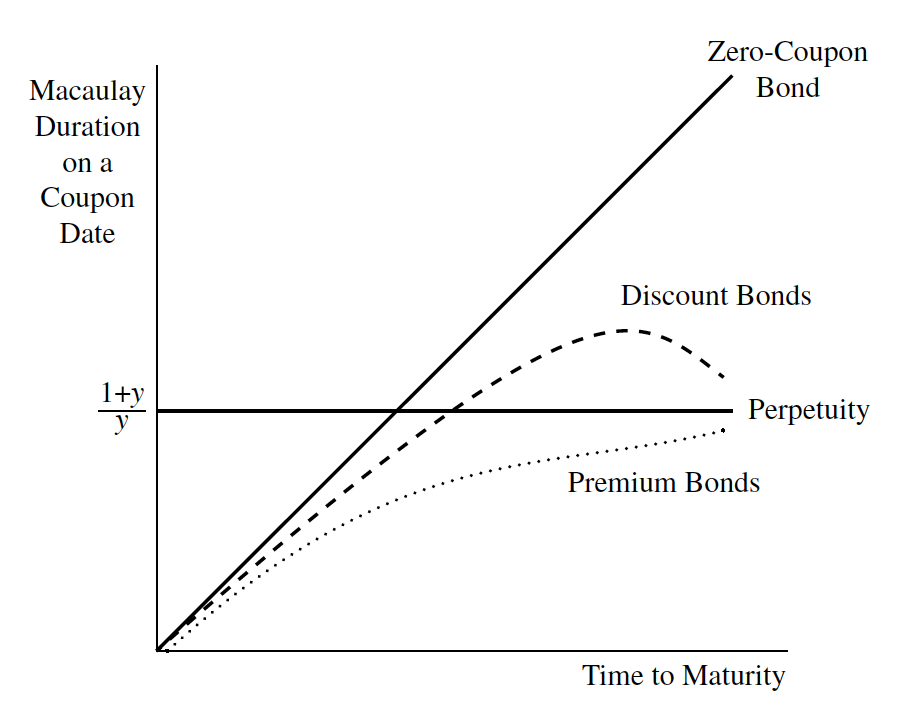

Let’s revisit the problem of the fixed‐income strategist considering two 6% annual payment bonds, one maturing in 20 years and the other in 30 years. Both are priced to yield 20% (discount bonds), and the strategist anticipates a 100 basis point drop. The easiest way to assess the choice is to do the basic bond pricing assuming we are on a coupon date.

In [13]:
coupon = 0.06
ytm = 0.2
N_1 = 20
N_2 = 30

delta_ytm = -0.01

price_1_t0 = coupon_bond_pv(N_1, coupon*100, ytm, 100, cf_freq=1, comp_freq=1)
price_1_t1 = coupon_bond_pv(N_1, coupon*100, ytm+delta_ytm, 100, cf_freq=1, comp_freq=1)
per_change_1 = (price_1_t1 / price_1_t0) - 1
macdur_1 = duration(N_1, r=ytm, c=coupon, tT=0, cf_freq=1, comp_freq=1, modified=False)

price_2_t0 = coupon_bond_pv(N_2, coupon*100, ytm, 100, cf_freq=1, comp_freq=1)
price_2_t1 = coupon_bond_pv(N_2, coupon*100, ytm+delta_ytm, 100, cf_freq=1, comp_freq=1)
per_change_2 = (price_2_t1 / price_2_t0) - 1
macdur_2 = duration(N_2, r=ytm, c=coupon, tT=0, cf_freq=1, comp_freq=1, modified=False)

print(f'{price_1_t0 = }')
print(f'{price_1_t1 = }')
print(f'{per_change_1 = :0.3%}')
print(f'{macdur_1 = :0.3}')
print()

print(f'{price_2_t0 = }')
print(f'{price_2_t1 = }')
print(f'{per_change_2 = :0.3%}')
print(f'{macdur_2 = :0.3}')

price_1_t0 = array(31.82588373)
price_1_t1 = array(33.68879223)
per_change_1 = 5.853%
macdur_1 = 6.66

price_2_t0 = array(30.29489042)
price_2_t1 = array(31.94944114)
per_change_2 = 5.461%
macdur_2 = 6.21


It’s true—given the same coupon rate and yield, the 20‐year bond actually does have the higher percentage price increase for the same drop in yield, 5.85% compared to 5.46%. This is a curious bit of bond math and is not easy to explain without appealing to duration. 

$$\frac{dMV}{MV}\approx\left(\frac{\partial MV}{\partial y}\times\frac{1}{MV}\times dy\right)$$

$$\text{Modified Duration}\equiv-\frac{\partial MV}{\partial y}\times\frac{1}{MV}=\frac{\text{Macaulay Duration}}{1+y}$$

$$\frac{dMV}{MV}\approx\left(-\text{Modified Duration}\times dy\right)$$

In [14]:
dMV_1 = -((macdur_1)/(1+ytm) * delta_ytm) 
print(f'{dMV_1 = :0.3}')
dMV_2 = -(macdur_2/(1+ytm) * delta_ytm) 
print(f'{dMV_2 = :0.3}')

dMV_1 = 0.0555
dMV_2 = 0.0517


Notice that duration signals correctly the bond that has the greater price appreciation if the market responds as the strategist expects. However, the estimated changes are off by about 30 basis points compared to the actual results. By itself, duration is a conservatively biased estimate for the risk in a long position on a fixed‐income bond—it overestimates the loss when the yield goes up and underestimates the gain when the yield goes down. The convexity adjustment improves the estimate in each case.

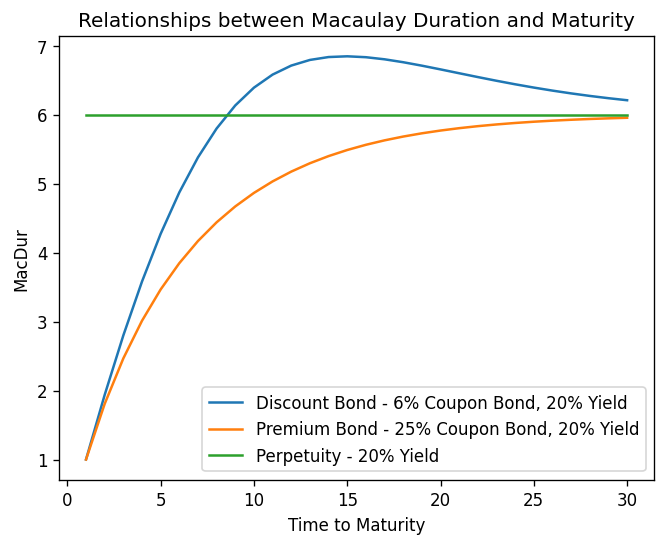

In [15]:
import matplotlib.pyplot as plt

Nlist = np.linspace(1, 30, num=30)
discount = duration(Nlist, r=0.2, c=0.06, tT=0, cf_freq=1, comp_freq=1, modified=False)
premium = duration(Nlist, r=0.2, c=0.25, tT=0, cf_freq=1, comp_freq=1, modified=False)
perpetuity = (1 + 0.2)/0.2 + (0 * Nlist)
zero_coupon = duration(Nlist, r=0.2, c=0.0, tT=0, cf_freq=1, comp_freq=1, modified=False)

plt.figure(num=0, dpi=120)
plt.plot(Nlist, discount, label="Discount Bond - 6% Coupon Bond, 20% Yield")
plt.plot(Nlist, premium, label="Premium Bond - 25% Coupon Bond, 20% Yield")
plt.plot(Nlist, perpetuity, label="Perpetuity - 20% Yield")
# plt.plot(Nlist, zero_coupon, label="Zero-Coupon Bond - 20% Yield")
plt.title('Relationships between Macaulay Duration and Maturity')
plt.xlabel('Time to Maturity')
plt.ylabel('MacDur')
plt.legend()

### Yield Convexity

The bond convexity statistic is the second-order effect in the Taylor series expansion. The **closed-form formula** is complicated enough to warrant 3 separate steps:

Step 1 - Convexity (t/T = 0):
$$Convexity(t/T=0)=\frac{\Big[2 \times c \times (1 + y)^{2} \times \Big((1+y)^{N} - \frac{1+y+(y \times N)}{1 + y}\Big) \Big] + [N \times (N + 1) \times y^{2} \times (y - c)]}{y^{2} \times (1+y)^{2} \times (c \times [(1+y)^{N}-1]+y)}$$

Step 2 - Macaulay Duration(t/T = 0):
$$MacDur(t/T=0)=\frac{1+y}{y}-\frac{1+y+\left\lbrack N\times\left(c-y\right)\right\rbrack}{c\times\left\lbrack\left(1+y\right)^{N}-1\right\rbrack +y}$$

Step 3 - Convexity:
$$Convexity=Convexity(t/T=0)-\Big\lbrace\frac{t/T}{(1+y)^{2}} \times [(2\times MacDur(t/T=0)) + (1-t/T)]\Big\rbrace$$


- c = the coupon rate per period
- y = yield to maturity per period
- N = number of periods to maturity

Zero-Coupon Bond Convexity (t/T = 0) when c = 0 (Step 1):

$$Convexity(t/T = 0)=N\times\frac{(N+1)}{(1+y)^{2}}

**Convexity** weighted-average formula:

Calculating Convexity of Cash Flow:

$$\text{Convexity of CF}_{n}=\left(p_{n}-\frac{t}{T}\right)\left(p_{n}-\frac{t}{T}+1\right)\left(\frac{PV_{CF_{n}}}{PV^{Full}}\right)\left(1+\frac{YTM}{m}\right)^{-m}$$

$$\text{Annualized Convexity}=\frac{\sum_{n=1}^{N}\text{Convexity of CF}_{n}}{m^2}$$

- $p_{n}$ = period of cash flow
- $t/T$ = accrual fraction
- $p_{n} - t/T$ = time from settlement when coupon is due
- $\frac{PV_{CF_{n}}}{PV^{Full}}$ = present value weighted cash flow at period *n*
- m = periods per year

In [16]:
def convexity(N, r, c, tT, cf_freq=2, comp_freq=2):
    y = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq
    Y = (1+y)**2
    Yn = (1+y)**N
    con_num = (2 * c * Y * (Yn - ((1+y+(y*N))/(1+y)))) + (N * (N + 1) * (y**2) * (y - c))
    con_den = (y**2) * Y * (c * (Yn - 1) + y)
    con = con_num / con_den
    macdur = ((1 + y)/y) - ((1 + y + (N * (c - y)))/(c * (Yn - 1) + y))
    con_tT = con - ((tT / Y) * (( 2 * macdur) + (1 - tT)))
    return con_tT/cf_freq**2

def convexity_cf(r, cf, cf_t=None, N=None, tT=0, cf_freq=2, comp_freq=2):
    r = equivRate(r, from_freq=cf_freq, to_freq=comp_freq) / cf_freq
    if cf_t is None:
        cf_t = np.arange(N) + 1 - tT
    pv_cf = cf * (1+r)**-cf_t
    weight = pv_cf / np.sum(pv_cf)
    cf_con = cf_t * (cf_t + 1) * weight * (1 + r)**-cf_freq
    return np.sum(cf_con)/cf_freq**2

Let’s work on a 4%, semiannual payment, 25‐year bond priced at a discount to yield 4.40% (s.a.).

In [17]:
freq = 2
N = 25 * freq
coupon = 0.04 / freq
ytm = 0.044
tT = 0.5

macdur = duration(N, ytm, coupon, tT=tT, cf_freq=2, comp_freq=2, modified=False)
moddur = duration(N, ytm, coupon, tT=tT, cf_freq=2, comp_freq=2, modified=True)
print(f'{macdur = :0.4f}')
print(f'{moddur = :0.4f}')

anncon = convexity(N, ytm, coupon, tT, 2, 2)
print(f'{anncon = :0.4f}')

macdur = 15.4656
moddur = 15.1327
anncon = 312.6860


In [18]:
cf_t = np.arange(N)+1 - tT
cf = np.full(N, coupon*100)
cf[-1] += 100
anncon = convexity_cf(r=ytm, cf=cf, cf_t=cf_t, cf_freq=freq, comp_freq=freq)
macdur = duration_cf(N=N,r=ytm, cf=cf, tT=tT, cf_freq=freq, comp_freq=freq, modified=False)
moddur = duration_cf(N=N,r=ytm, cf=cf, tT=tT, cf_freq=freq, comp_freq=freq, modified=True)

print(f'{macdur = :0.4f}')
print(f'{moddur = :0.4f}')
print(f'{anncon = :0.4f}')

macdur = 15.4656
moddur = 15.1327
anncon = 312.6860


In [19]:
from prettytable import PrettyTable

freq = 2
coupon = 4 / freq
N = 25 * freq
ytm = 0.044 # coupon_bond_ytm(N, coupon, price, 100, cf_freq=1, comp_freq=1)
tT = 90/180

# Time to Receipt of Cash Flows
cf_t = np.arange(N) + 1 - tT

# Bond Cash Flows
cf = np.full(N, coupon)
cf[-1] += 100

# Discount Factor
df = (1 + ytm/freq)**-cf_t

# Present Value of Cash Flows
pv_cf = cf * df

# Time Weighted Present Value of Cash Flows
weight = pv_cf / np.sum(pv_cf)
time_weighted = weight * cf_t

# Convexity 
cf_con = (cf_t * (cf_t + 1)) * weight * ((1 + ytm/freq)**-freq)

# Duration computations
macdur = np.sum(time_weighted) / freq
moddur = macdur / (1 + ytm / freq)
con = np.sum(cf_con)
anncon = con / freq**2

# Output Table
table = PrettyTable()
table.add_column("Period", np.arange(N)+1)
table.add_column("Time to Receipt", np.round(cf_t, 4))
table.add_column("Cash Flow", cf)
table.add_column("PV", np.round(pv_cf, 4))
table.add_column("Weight", np.round(weight, 4))
table.add_column("Time Weighted", np.round(time_weighted, 4))
table.add_column("Convexity of CF", np.round(cf_con, 4))
print(table)

print(f'{macdur = :0.4f}')
print(f'{moddur = :0.4f}')
print(f'{con = :0.4f}')
print(f'{anncon = :0.4f}')

+--------+-----------------+-----------+---------+--------+---------------+-----------------+
| Period | Time to Receipt | Cash Flow |    PV   | Weight | Time Weighted | Convexity of CF |
+--------+-----------------+-----------+---------+--------+---------------+-----------------+
|   1    |       0.5       |    2.0    |  1.9784 | 0.0208 |     0.0104    |      0.015      |
|   2    |       1.5       |    2.0    |  1.9358 | 0.0204 |     0.0306    |      0.0732     |
|   3    |       2.5       |    2.0    |  1.8941 | 0.0199 |     0.0498    |      0.167      |
|   4    |       3.5       |    2.0    |  1.8533 | 0.0195 |     0.0683    |      0.2942     |
|   5    |       4.5       |    2.0    |  1.8134 | 0.0191 |     0.0859    |      0.4523     |
|   6    |       5.5       |    2.0    |  1.7744 | 0.0187 |     0.1027    |      0.6393     |
|   7    |       6.5       |    2.0    |  1.7362 | 0.0183 |     0.1188    |      0.853      |
|   8    |       7.5       |    2.0    |  1.6988 | 0.0179 | 

### Tests

In [20]:
def duration1(cf, rate, cf_freq=1, comp_freq=1, cf_t=None,
             immediate_start=False, modified=False):

    def one_duration(rate, cf_freq, comp_freq, immediate_start):
        if cf_t is None:
            start = 0 if immediate_start else 1/cf_freq
            stop = start + len(cf) / cf_freq
            cf_ta = np.arange(start=start, step=1/cf_freq, stop=stop)
        else:
            cf_ta = cf_t
        print(cf_ta)
        cc_rate = equivRate(rate, from_freq=comp_freq, to_freq=np.inf)
        df = np.exp(-cc_rate * cf_ta)
        return np.dot(cf*df, cf_ta) / np.dot(cf, df)

    D = np.vectorize(one_duration)(
        rate=rate, cf_freq=cf_freq, comp_freq=comp_freq,
        immediate_start=immediate_start)
    D /= np.where(modified, 1 + rate/comp_freq, 1)
    return D[()]

cf=np.full(28*2, 6)
rate = 0.12792

print(duration1(cf,rate,  cf_freq=2, comp_freq=2, cf_t=np.arange(28*2)+1))

print(duration_cf(28*2, rate, cf, tT=0, cf_freq=2, comp_freq=2))

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56]
8.52106097910871
6.973821133236226


In [21]:
def duration1(cf, rate, cf_freq=1, comp_freq=1, cf_t=None,
             immediate_start=False, modified=False):

    def one_duration(rate, cf_freq, comp_freq, immediate_start):
        if cf_t is None:
            start = 0 if immediate_start else 1/cf_freq
            stop = start + len(cf) / cf_freq
            cf_ta = np.arange(start=start, step=1/cf_freq, stop=stop)
        else:
            cf_ta = cf_t
        print(cf_ta)
        cc_rate = equivRate(rate, from_freq=comp_freq, to_freq=np.inf)
        df = np.exp(-cc_rate * cf_ta)
        return np.dot(cf*df, cf_ta) / np.dot(cf, df)

    D = np.vectorize(one_duration)(
        rate=rate, cf_freq=cf_freq, comp_freq=comp_freq,
        immediate_start=immediate_start)
    D /= np.where(modified, 1 + rate/comp_freq, 1)
    return D[()]

cf=[100, 50, 75, 25]
rate = 10e-2

print(duration1(cf,rate, cf_freq=1, comp_freq=1))

print(duration_cf(4, rate, cf, tT=0, cf_freq=1, comp_freq=1))

[1. 2. 3. 4.]
[1. 2. 3. 4.]
1.9980073065426769
1.8163702786751608
